# Dataiku Chalenge

### Load necessary libraries

In [1]:
import pandas as pd
import pandas_profiling
import numpy as np
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import matplotlib.pyplot as plt   
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import SelectFromModel
import matplotlib.pylab as pl
import shap

### Load in US Census Data

In [2]:
df_train = pd.read_csv('/Users/bparks/Downloads/us_census_full/census_income_learn.csv')
df_test = pd.read_csv('/Users/bparks/Downloads/us_census_full/census_income_test.csv')

### Load in Metadata for column names

In [13]:
with open('/Users/bparks/Downloads/us_census_full/census_income_metadata.txt', 'r') as file:
    data = file.read()
    
columns_raw = data.split('| Information about .data file : \n|   ')[1]\
    .split(' \n|\n| Error rates:')[0]

col_list = []
for i in columns_raw.split('\n| '):
    split_on_tabs = i.split('(')[1].split(')')[0]
    col_list.append(split_on_tabs.replace(' ', '_'))
col_list.append('income_target')

### Clean and Prepare data

In [4]:
#build fuction to prep data for analysis

def prep_data(df):
    
    # drop instance_weight column
    df = df.drop(df.columns[24], axis=1)
    
    #assign column names to training and test set
    df.columns = col_list[0:41]
    
    # reassign incorrectly inferred datatypes
    df = df.astype({'class_of_worker': 'object'
                    , 'class_of_worker': 'object'
                    , 'detailed_industry_recode': 'object'
                    , 'detailed_occupation_recode': 'object'
                    , 'own_business_or_self_employed': 'object'
                    , 'year': 'object'})
    
    # Get dummy variables for categorical columns
    cat_columns = []
    for col, type in zip(df.columns, df.dtypes):
        if type == object:
            cat_columns.append(col)
        
    cat_columns = cat_columns[:-1]
    
    df_processed = pd.get_dummies(df, prefix_sep="__",
                              columns=cat_columns)
    
    df_processed = df_processed[[c for c in df_processed if c not in ['income_target']] 
       + ['income_target']]
    
    # Encode target variable to a 1/0 value instead of a string
    df_processed['income_target'] = np.where(df_processed['income_target'] == ' - 50000.', 0, 1)
    
    # separate target variable from independent variables
    X = df_processed[df_processed.columns[0:-1]]
    y = df_processed[df_processed.columns[-1]]
    
    # replace characters not accepted by ML algorithms
    X.columns = [i.replace('<', 'lessthan').replace(', ', ' ') for i in X.columns]
    
    return (X,y)

In [5]:
# Use prep_data function to get cleaned train and test sets

X_train, y_train = prep_data(df_train)
X_test, y_test = prep_data(df_test)

In [6]:
# Exploratory analysis of variables

profile = df_train.profile_report(title='Pandas Profiling Report')
profile.to_file(output_file="pandas_profiling_analysis.html")

## Feature Selection Loop using Xgboost and importance thresholds

In [7]:
# split training data into training and validation sets
X_train_set, X_validate_set, y_train_set, y_validate_set = train_test_split(X_train, y_train, test_size=0.33, random_state=7)

# fit model on all training data
model = XGBClassifier(scale_pos_weight=20, learning_rate=0.1, nthread=6)
model.fit(X_train_set, y_train_set)

# make predictions for test data and evaluate
y_pred = model.predict(X_validate_set)
roc_auc = roc_auc_score(y_validate_set,y_pred)
print("All features,  ROC AUC: " + str(round(roc_auc, 2)))

# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)[::-1][0:20]
for thresh in thresholds:
    
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train_set)
    
    # train model
    selection_model = XGBClassifier(scale_pos_weight=20, learning_rate=0.1, nthread=6)
    selection_model.fit(select_X_train, y_train_set)
    
    # evaluate model
    select_X_test = selection.transform(X_validate_set)
    y_pred = selection_model.predict(select_X_test)
    roc_auc = roc_auc_score(y_validate_set,y_pred)
    accuracy = accuracy_score(y_validate_set,y_pred)
    print("Threshold=%.3f, n_features=%d, ROC AUC: %.2f, Accuracy Score: %.2f%%" % (thresh, select_X_train.shape[1], roc_auc, accuracy))

All features,  ROC AUC: 0.87
Threshold=0.204, n_features=1, ROC AUC: 0.77, Accuracy Score: 0.64%
Threshold=0.093, n_features=2, ROC AUC: 0.77, Accuracy Score: 0.64%
Threshold=0.072, n_features=3, ROC AUC: 0.77, Accuracy Score: 0.64%
Threshold=0.055, n_features=4, ROC AUC: 0.78, Accuracy Score: 0.67%
Threshold=0.043, n_features=5, ROC AUC: 0.79, Accuracy Score: 0.66%
Threshold=0.037, n_features=6, ROC AUC: 0.80, Accuracy Score: 0.76%
Threshold=0.035, n_features=7, ROC AUC: 0.82, Accuracy Score: 0.72%
Threshold=0.035, n_features=8, ROC AUC: 0.83, Accuracy Score: 0.75%
Threshold=0.034, n_features=9, ROC AUC: 0.85, Accuracy Score: 0.78%
Threshold=0.028, n_features=10, ROC AUC: 0.85, Accuracy Score: 0.79%
Threshold=0.020, n_features=11, ROC AUC: 0.85, Accuracy Score: 0.79%
Threshold=0.020, n_features=12, ROC AUC: 0.85, Accuracy Score: 0.79%
Threshold=0.020, n_features=13, ROC AUC: 0.85, Accuracy Score: 0.79%
Threshold=0.018, n_features=14, ROC AUC: 0.86, Accuracy Score: 0.81%
Threshold=0.01

## Feature Selection Results

#### As we see from the above loop, we don't start to lose a significant amount of area under the curve (AUC) or accuracy until around 9 of the top features are used. For this reason, The final model will use the top 9 features from.

## --------------------

## Train models (Xgboost, logistic regression) using selected features

In [8]:
# select top 9 features

selected_features = list(pd.DataFrame({'col':X_train.columns, 'feature_importance':model.feature_importances_}).sort_values('feature_importance', ascending=False).col)[0:9]

# train models using these features on the training data

# Logistic Regression
logit = LogisticRegression(class_weight='balanced', solver = 'liblinear', max_iter = 10000)
logit.fit(X_train.loc[:,selected_features], y_train)

# XGBoost
xgb = XGBClassifier(scale_pos_weight=20, learning_rate=0.1, nthread=6)
xgb.fit(X_train.loc[:,selected_features], y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=6, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=20, seed=None,
              silent=None, subsample=1, verbosity=1)

## Evaluate Models

XGBoost
ROC AUC: 0.8455034287950721 Accuracy Score: 0.7872014113731819
Logistic Regression
ROC AUC: 0.8383569623098153 Accuracy Score: 0.7988592736640571

 
Due to it's higher AUC, XGBoost will be the final model 
 
 
XGBoost Confusion Matrix


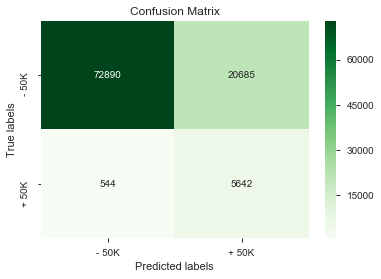

In [11]:
# evaluate models against test dataset

y_pred = xgb.predict(X_test.loc[:,selected_features])
roc_auc = roc_auc_score(y_test,y_pred)
accuracy = accuracy_score(y_test,y_pred)

y_pred_l = logit.predict(X_test.loc[:,selected_features])
roc_auc_l = roc_auc_score(y_test,y_pred_l)
accuracy_l = accuracy_score(y_test,y_pred_l)

print("XGBoost")
print("ROC AUC: " + str(roc_auc), "Accuracy Score: " + str(accuracy))

print("Logistic Regression")
print("ROC AUC: " + str(roc_auc_l), "Accuracy Score: " + str(accuracy_l))

print("\n \nDue to it's higher AUC, XGBoost will be the final model \n \n ")

cm = confusion_matrix(y_test, y_pred)

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g', cmap='Greens')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['- 50K', '+ 50K'])
ax.yaxis.set_ticklabels(['- 50K', '+ 50K'])

print("XGBoost Confusion Matrix")

## Visualizing Variable Effects

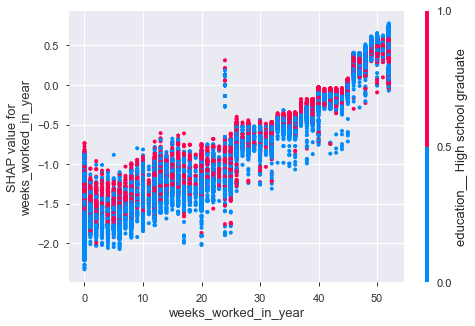

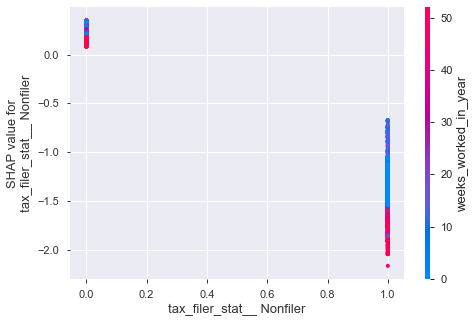

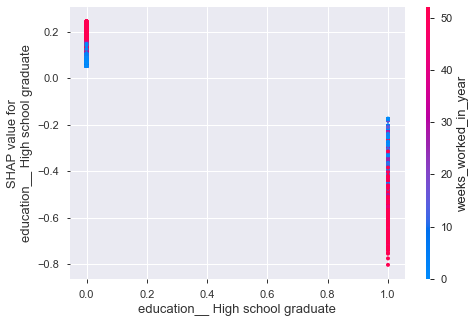

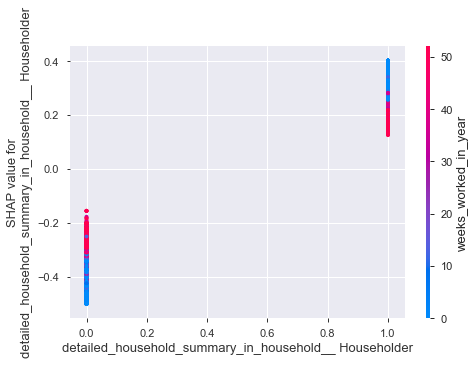

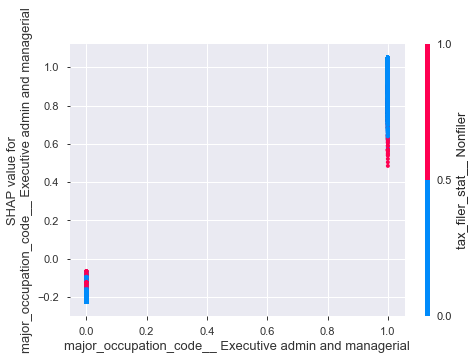

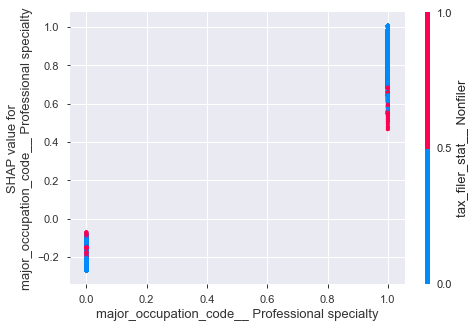

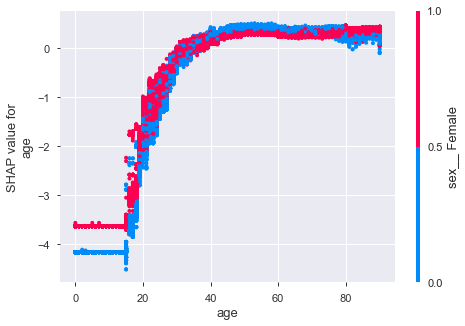

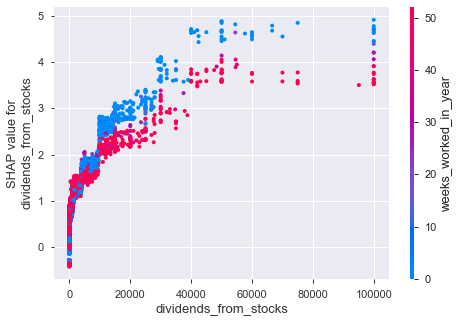

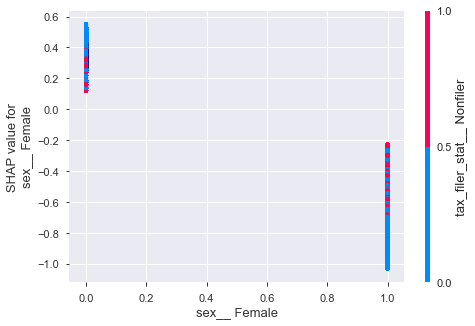

In [10]:
# charts visualizing the effect of variables (A higher SHAP value contributes to a higher likelihood of a '1' class)

shap.initjs()
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_train.loc[:,selected_features])

for i in selected_features:
    shap.dependence_plot(i, shap_values, X_train.loc[:,selected_features])